In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%matplotlib inline
%load_ext autoreload
# %autoreload 2

In [3]:
!pwd


/content


In [4]:
!pwd
%cd /content/drive/My\ Drive/


/content
/content/drive/My Drive


In [5]:
%cd Colab Notebooks (1)/Release_All_final

/content/drive/My Drive/Colab Notebooks (1)/Release_All_final


In [6]:

from __future__ import print_function
import os                                    
import sys
import numpy as np 
import torch
from matplotlib import pyplot
import warnings
warnings.filterwarnings("ignore")

# BusterNet Performance On the CoMoFoD Dataset

# 1. Load the pretrained BusterNet model

In [7]:
cuda = True
model_dir =  './trained_model'
CoMoFoD_hd5 = '/content/drive/MyDrive/datasets/ CoMoFoD-CMFD.hd5'

sys.path.insert( 0, model_dir )
from net import BusterNet
model = BusterNet(256)

model.load_state_dict(torch.load('trained_model/buster_epoch_13.pth'))
if cuda: 
    model = model.cuda()

# 2. Load the CoMoFoD-CMFD Dataset

In [8]:
import h5py
#CoMoFoD_hd5 = '/content/drive/MyDrive/datasets/ CoMoFoD-CMFD.hd5'
f = h5py.File(CoMoFoD_hd5, 'r')
# 1. load HDF5 data
print(f.keys())
# print(f['X'].shape)
X  = f['X']
XN = f['XN']
Y  = f['Y']
YN = f['YN']
print(X.shape, XN.shape, Y.shape, YN.shape)

<KeysViewHDF5 ['X', 'XN', 'Y', 'YN']>
(5000, 256, 256, 3) (5000,) (200, 256, 256, 3) (200,)


In [9]:
# Z = busterNetModel.predict(X, verbose=1)

batch_size = 16
size = len(X) // batch_size
Z = []
for i in range(size + 1):
    if batch_size == size:
        x = X[i * batch_size:]
    else:
        x = X[i * batch_size: (i + 1) * batch_size]
    x = torch.tensor(x).permute(0, 3, 1, 2)
    
    if cuda:
        x = x.cuda()

    model.eval()
    with torch.no_grad():
        z, _, _ = model(x)
    Z.append(z.cpu())
    
Z = torch.cat(Z)


In [10]:
Z.shape

torch.Size([5000, 3, 256, 256])

# 3. BusterNet Performance on CoMoFoD Dataset (Table 3)

In [11]:
!pip install parse

  Created wheel for parse: filename=parse-1.18.0-cp36-none-any.whl size=24133 sha256=3c9fa11bcaadbccfacfbc743d3471d5a8774b815b84bd710b10a9277919cb64a
  Stored in directory: /root/.cache/pip/wheels/2a/53/09/869ca5781ede342254ffac09ca99461b008c3e5f8dd079b0c0
Successfully built parse


In [13]:
from parse import parse
from sklearn.metrics import precision_recall_fscore_support

def get_target_idx( xn, ynames ) :
    xn = xn.decode("utf-8")
    fmt = '{}_F_{}'
    try :
        img_id, postproc = parse( fmt, xn )
    except :
        img_id = xn.rsplit('_')[0]
        postproc = 'BASE'
    idx = ynames.index( img_id )
    return idx, img_id, postproc

def evaluate_CoMoFoD_performance( Z, XN, Y, YN ) :
    # 1. prepare target names
    ynames = []
    for yn in YN :
        ynames.append(yn.decode("utf-8"))
    # 2. evaluate performance for each sample
    plut = {'mapping':{}}
    for xidx, (xn, z) in enumerate( zip( XN, Z ) ) :
        # 3. get corresponding target file
        idx, img_id, postproc = get_target_idx( xn, ynames )
        y = Y[idx]
        # 4. evaluate performance
        if postproc not in plut :
            plut[postproc] = []
        ref = y[...,2].ravel() == 0
        hyp = z[...,2].ravel() <= 0.5
        precision, recall, fscore, _ = precision_recall_fscore_support( ref, hyp,
                                                                        pos_label=1, 
                                                                        average='binary' )
        plut[postproc].append( [precision, recall, fscore] )
        if postproc == 'BASE' :
            plut['mapping'][xidx] = [idx, fscore]
    # 5. show results
    print( "INFO: BusterNet Performance on CoMoFoD-CMFD Dataset using the number of correct detections" )
    print("-" * 100)
    for key, res in sorted( plut.items() ) :
        if key == 'mapping' :
            continue
        # a sample is correct if its F1 score is above 0.5
        nb_correct = np.sum( np.row_stack(res)[:,-1] > .5 )
        print ("{:>4s}: {:>3}".format( key, nb_correct ) )
    return plut
        

In [14]:
XN[:10]
YN[:10]

array([b'130', b'043', b'003', b'170', b'098', b'083', b'018', b'058',
       b'095', b'126'], dtype='|S10')

In [16]:
Z_np = Z.permute(0, 2, 3, 1).numpy()
plut = evaluate_CoMoFoD_performance( Z_np, XN, Y, YN )

KeyboardInterrupt: ignored

# 4. Plot Performance Curves

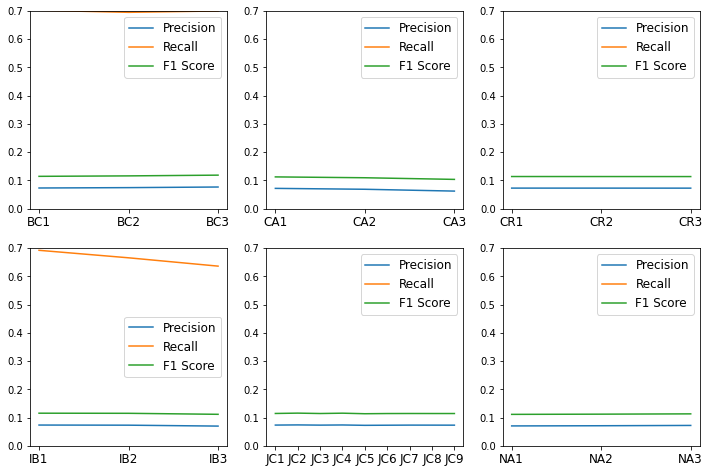

In [ ]:
llut = { 'Bright Change(BC)' : range(1,4), 'Contrast Adjustment(CA)' : range(4,7),
        'Color Reduction(CR)' : range(7,10), 'Image Blurring(IB)' : range(10,13), 
        'JPEG Compression(JC)' : range(13,22), 'Noise Adding(NA)' : range(22,25) }

pyplot.figure(figsize=(12,8))
ii = 1
for key, vals in llut.items() :
    ys = []
    xnames = []
    for idx, val in enumerate(vals) :
        _, prefix = parse( '{}({})', key)
        tkey = prefix + str(idx+1)
        ys.append( np.mean( np.row_stack( plut[tkey] ), axis=0) )
        xnames.append( tkey )
    pyplot.subplot(2,3,ii)
    pyplot.plot( np.array(ys) )
    pyplot.xticks( range(len(vals)), xnames, fontsize=12 )
    pyplot.legend(['Precision', 'Recall', 'F1 Score'], fontsize=12 )
    pyplot.ylim([0,.7])
    ii += 1

# 5. Generate qualitative results

In [27]:
def visualize_random_samples( X, Y, Z, prf_lut, batch_size=1, figsize=(12,4),  thresh=0.3 ) :
    nb_samples = X.shape[0]
    ynames = []
    for yn in YN :
        ynames.append(yn)
    if prf_lut is None :
        print("INFO: show random results")
        indices = np.random.choice( prf_lut['mapping'].keys(), size=(batch_size,))
    else :
        print("INFO: show random results with F1 score > {}".format( thresh ) )
        candi = list( filter(None, [ xidx if f1>thresh else None for xidx, ( yidx, f1 ) in prf_lut['mapping'].items() ] ) )
        indices = np.random.choice( candi, size=(batch_size,))
    for idx in indices :
        # 1. add back imageNet BGR means
        x = np.array(X[idx]) + np.array([103.939, 116.779, 123.68]).reshape([1,1,3])
        # 2. restore image dtype and BGR->RGB
        x = np.round(x).astype('uint8')[...,::-1]
        # 3. set gt to float
        yidx, f1 = prf_lut['mapping'][idx]
        y = np.array(Y[yidx]).astype('float32')
        z = np.array(Z[idx])
        # 4. display
        pyplot.figure(figsize=figsize)
        pyplot.subplot(131)
        pyplot.imshow( x )
        pyplot.title('test image')
        pyplot.subplot(132)
        pyplot.imshow( y )
        pyplot.title('ground truth')
        pyplot.subplot(133)
        pyplot.imshow( z )
        pyplot.title('Modified BusterNet predicted')
    return

INFO: show random results with F1 score > 0.5


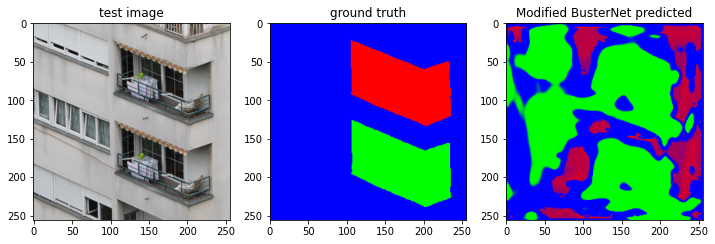

In [28]:
visualize_random_samples( X, Y, Z_np, prf_lut=plut, thresh=0.5 )